In [1]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time

In [4]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [5]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [19]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id',] #'click_environment','click_deviceGroup']
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [20]:
user_clicks = get_click_data()

In [21]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


user_id             322897
click_article_id     46033
dtype: int64

# Train/Test Split

In [1]:
def train_test_split(df, size, leftover_size):
    df = df[df.groupby('user_id').user_id.transform(len) >= (size + leftover_size)]
    size = 8        # sample size per user
    replace = False  # without replacement
    fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    df_train = df.groupby('user_id', as_index=False).apply(fn)
    df_test = df[~df.index.isin(df_train.index)]
    
    return df_train, df_test

In [32]:
df_train, df_test = train_test_split(user_clicks,8,2)

In [33]:
df_sample = df_train[0:800]

In [34]:
df_train.to_csv('data/df_train.csv')
df_test.to_csv('data/df_test.csv')
df_sample.to_csv('data/df_sample.csv')

In [35]:
print(df_train.shape)
print(df_test.shape)
print(df_sample.shape)

(684405, 2)
(2027773, 2)
(800, 2)


### Read Back

In [7]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

In [5]:
df_sample = pd.read_csv('data/df_sample.csv')

# Model 1: Linear Factorization

In [6]:
class LinearModel:
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.T = T
        self.Vd = LinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.reset_errors()
        
    def initialize_user_vectors(self,size,embeddings_size=250):
        return np.mean(LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        ),axis=1) #[:,np.newaxis]
        
    def reset_errors(self):
        #this is for tracking in steps of GD
        self.errors = []
    
    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, len_=364047):            
            #semi-vectorized version
            
            return df.user_id.drop_duplicates().map(
                lambda u: LinearModel.dbar.get_unseen(df, u, size, len_)
            )
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250, len_=36047):
            return np.hstack(
                V_embeddings[LinearModel.dbar.get_all_unseen(df,size,len_=len_).tolist()]
            ).reshape(
                -1,
                size,
                embeddings_size
            )
    
    ########################
    ##### GD UTILITIES #####
    ########################
    
    class gradient: 
        @staticmethod
        def J(U,Vd,Vdbar, repeat=1, size=8, embedding_size=250,hinge_param=1):
            '''
            Cost for linear model.
            Size refers to size of axis 1 for max function (hinge loss)
            '''

            cost = hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
            
            
            return np.sum(
                np.max(
                    [np.zeros((U.shape[0]*size)), cost.ravel()], axis = 0
                )
            )
        
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            #conditional derivitive
            
            return np.sum(
                (
                    hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0]
                    - np.tensordot(U,Vd,axes=(1,2))[0] < 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
    
    def gradient_descent_linear(
        self,
        alpha=0.1,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):
        #Stochastic Gradient Descent

        #print('Vd', self.item_embeddings[0,0:10])
        
        #resample stuff
        Vdbar_small = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size,
        )

        self.U = self.U - alpha * LinearModel.gradient.dJ(
            self.U,
            self.Vd,
            Vdbar_small,
        ) #fix this
        
        
        while True:
            if test == True:
                Vdbar_big = LinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    test_size,
                    embeddings_size=embeddings_size,
                )
                
                J = LinearModel.gradient.J(
                    self.U,
                    self.Vd.repeat(test_size/size,axis=1),
                    Vdbar_big,
                    size=test_size,
                    embedding_size=250,
                    hinge_param=1
                )
                # the Vd reshape still needs to be fixed
                
                self.errors.append(J)
                
            if iteration == max_iterations:
                #stop iterating
                #display errors
                plt.figure(figsize=(12,8))
                plt.xlabel('Iterations')
                sns.lineplot(
                    x = range(len(self.errors)),
                    y = self.errors
                )
                return self.U
            #print(iteration)
            iteration += 1
            return self.gradient_descent_linear(
                alpha=alpha, 
                size=size,
                test_size=test_size,
                embeddings_size=embeddings_size,
                test=test, 
                hinge_param=hinge_param,
                iteration=iteration, 
                max_iterations=max_iterations)

# Model 2: Multiple User Latent Vectors

In [35]:
class NonlinearModel(LinearModel):
    def initialize_user_vectors(self,size,embeddings_size):
        '''
        sets self.U in parent class __init__
        '''
        starting_vectors = LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        )
        
        return NonlinearModel.Cluster.k_means(starting_vectors,self.T)
    
    
    class Cluster():
        @staticmethod
        def starting_centroids(points,T):
            '''
            initialize centroids by randomly picking an item for each user
            '''
            starter_idx = np.random.rand(points.shape[0],T).argsort(axis=-1)[:,0:T,np.newaxis]
            return np.take_along_axis(
                points,
                starter_idx,
                axis=1
            )

        @staticmethod
        def closest_centroid(points, centroids):
            '''
            find the closest centroid to each point
            '''
            return np.argmin(
                np.square(
                    np.sum(
                        np.square(points[:,:,np.newaxis] - centroids[:,np.newaxis]),
                        axis=3
                    ),
                ),
                axis=2
            )

        @staticmethod
        def move_centroids(points,closest,k):
            '''
            find new centroid based on cluster center from cluster_centroid
            '''
            weights = np.equal(
                np.arange(k)[np.newaxis,:,np.newaxis],
                closest[:,np.newaxis,:]
            )

            weights = np.repeat(weights[:,:,:,np.newaxis],points.shape[2],axis=3)

            points = np.repeat(points[:,np.newaxis],k,axis=1)

            return np.average(
                points,
                weights = weights,
                axis=2
            )

        @staticmethod
        def k_means(starting_vectors,k):
            '''
            Description Here
            '''
            def iterative_kmeans(starting_vectors,old_centroids, new_centroids,k):
                while True:
                    if np.all(new_centroids == old_centroids):
                        return new_centroids
                    else:
                        old_centroids = new_centroids
                        new_centroids = NonlinearModel.Cluster.move_centroids(
                            starting_vectors,
                            NonlinearModel.Cluster.closest_centroid(
                                starting_vectors,
                                old_centroids
                                ),                                           
                            k,
                        )
                        iterative_kmeans(starting_vectors,old_centroids,new_centroids,k)
            starting_centroids = NonlinearModel.Cluster.starting_centroids(starting_vectors,k)
            return iterative_kmeans(
                starting_vectors,
                np.zeros(starting_centroids.shape),
                starting_centroids,
                k
            )
    

    class gradient():
        @staticmethod
        def argmax_indices(U,Vd):
            '''
            get which interest unit per user, per item, is best for each of their relevant items, d
            output of tensor dot should be 100 x 8 x 3
            output of argmax should be 100 x 8
            '''
            return np.argmax(
                np.tensordot(
                    Vd,
                    U,
                    axes=(2,2)
                )[:,:,0],
                axis=2
            )
        
        @staticmethod
        def dJi(Ui,argmax_indices,Vd,Vdbar,T,hinge_param=1):
            # Ui has only the relevant vector, U has all vectors
            cond = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0] > 0
            g = Vdbar - Vd
            partial_gradient = g * cond[:,:,np.newaxis]
            broadcast_gradient=partial_gradient[:,np.newaxis].repeat(T,axis=1)
            boolean_matrix = np.equal(argmax_indices[:,np.newaxis],np.arange(T)[np.newaxis,:,np.newaxis])
            return np.sum(broadcast_gradient * boolean_matrix[:,:,:,np.newaxis], axis=2)
        
        @staticmethod
        def J(Ui,Vd,Vdbar,hinge_param=1):
            cost = hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0,0] - np.tensordot(Ui,Vd,axes=(2,2))[0,0]
            return np.sum(
                np.max(
                    [np.zeros((cost.shape[0],cost.shape[1])), cost], axis = 1
                )
            )

        
    def get_Vdbar_test(self,test_size=128,embeddings_size=250):
        self.Vdbar_test = LinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                test_size,
                embeddings_size=embeddings_size,
            )
        
        

    def gradient_descent_nonlinear(
        self,
        alpha=0.01,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):

        argmax_indices = NonlinearModel.gradient.argmax_indices(self.U,self.Vd)
        
        Ui = np.take_along_axis(
            self.U,
            argmax_indices[:,:,np.newaxis],
            axis=1
        )
        
        Vdbar = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size,
        )
        
        self.U -= alpha * NonlinearModel.gradient.dJi(Ui,argmax_indices,self.Vd,Vdbar,self.T,hinge_param=hinge_param)
        
        if test == True:
            #get Vdbar
            Vdbar_test = LinearModel.dbar.get_embedding_vectors(
                self.item_embeddings,
                self.user_data,
                test_size,
                embeddings_size=embeddings_size,
            )
            
            
            
            self.errors.append(
                NonlinearModel.gradient.J(Ui,self.Vd.repeat(test_size/size,axis=1),Vdbar_test,hinge_param=1)
            )
        
        if iteration == max_iterations:
                if test == True:
                    
                    plt.figure(figsize=(12,8))
                    plt.xlabel('Iterations')
                    sns.lineplot(
                        x = range(len(self.errors)),
                        y = self.errors
                    )
                    
                    return None
        iteration += 1
        return self.gradient_descent_nonlinear(
            alpha=alpha,
            size=size,
            test_size=test_size,
            embeddings_size=embeddings_size,
            test=test,
            hinge_param=hinge_param,
            iteration=iteration,
            max_iterations=max_iterations
    )

# Test Models
### Linear Model

In [28]:
lm = LinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0:3,0:10])

[[-0.29646125 -0.9619813  -0.385169   -0.15401676 -0.1726656  -0.13469934
  -0.43434936 -0.0300447   0.1256653   0.05415066]
 [-0.5805663  -0.96820724 -0.2830381  -0.51715887 -0.1854958  -0.15514725
  -0.3823168  -0.18502773  0.08984882 -0.16653082]
 [-0.19002968 -0.9703981  -0.21350573 -0.36327484 -0.52580327 -0.11400038
   0.19791931  0.03186698  0.33862725  0.08496387]]


158.23645305633545 seconds


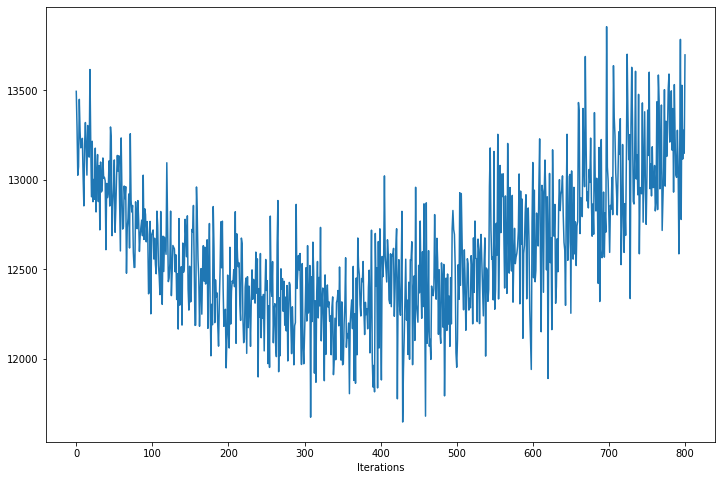

In [12]:
lm.reset_errors()
start = time()
lm.gradient_descent_linear(test=True,alpha=0.0001, max_iterations=800, test_size=128, hinge_param = 1)
print(time() - start, 'seconds')

### Nonlinear Model

In [40]:
nm = NonlinearModel(df_sample,embeddings,size=8, embeddings_size=250, T=3)
print(nm.U[0:3,:,0:10])

[[[-4.09697711e-01 -9.51300085e-01 -3.68948638e-01 -1.54123768e-01
    8.31604153e-02  2.81519353e-01 -6.81944370e-01 -2.08377331e-01
   -4.88360554e-01  3.26055020e-01]
  [-1.43459380e-01 -9.62325096e-01 -2.62884527e-01 -2.10758239e-01
   -6.58302605e-01 -6.02302551e-01 -1.15489423e-01 -8.20993185e-02
    3.50465655e-01 -3.68998408e-01]
  [-3.16343963e-01 -9.67150033e-01 -4.54421401e-01 -1.25592515e-01
   -5.77600971e-02 -1.09007105e-01 -4.69981909e-01  8.51489380e-02
    3.20278078e-01  1.29772991e-01]]

 [[-6.03582859e-01 -9.74321723e-01  1.74005479e-01 -8.46020103e-01
   -4.85560566e-01  2.83905149e-01  3.05400699e-01 -2.10794777e-01
    5.05345315e-02  1.03260383e-01]
  [-3.29614580e-01 -9.70748663e-01 -2.23241776e-01 -2.96942860e-01
    1.96437538e-03 -1.55467629e-01 -5.58442056e-01 -1.89327449e-03
    3.08049440e-01  6.23149723e-02]
  [-6.94533825e-01 -9.63879347e-01 -5.41458070e-01 -4.62836176e-01
   -1.29193455e-01 -3.74513268e-01 -6.38112903e-01 -2.63711423e-01
    4.05684114

155.09241700172424 seconds


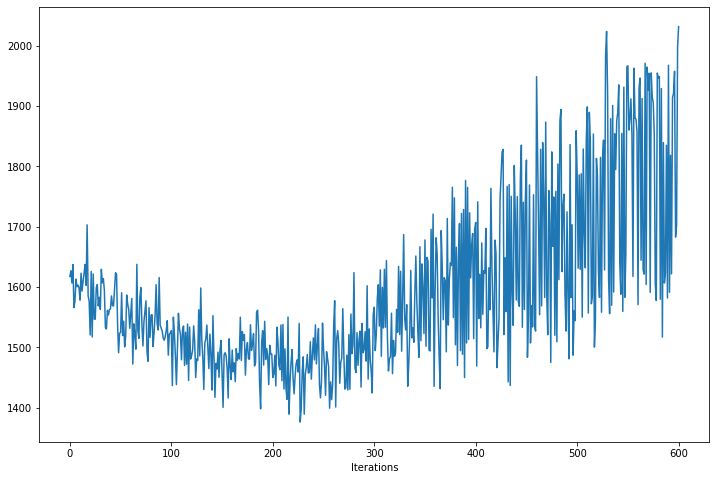

In [36]:
# df_x = pd.read_csv('data/df_x.csv')
# nm = NonlinearModel(df_x,embeddings,size=8, embeddings_size=250, T=3)
nm.reset_errors()
start = time()
nm.gradient_descent_nonlinear(test=True,alpha=0.001, max_iterations=600, test_size=64, hinge_param = 25)
print(time() - start, 'seconds')

139.36149978637695 seconds


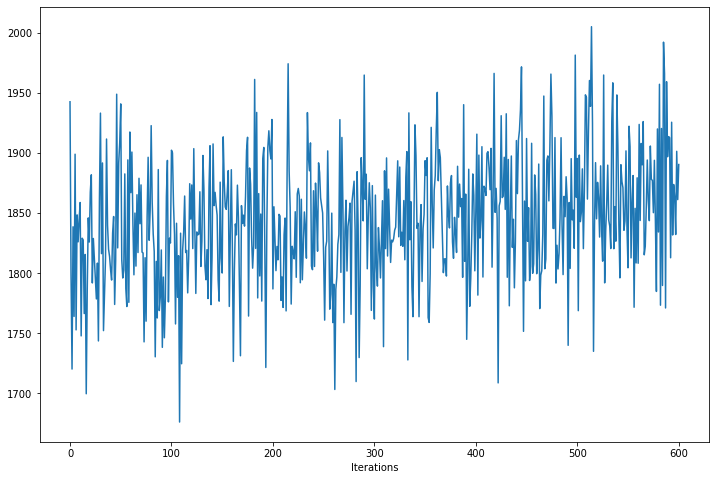

In [42]:
#df_sample
nm.reset_errors()
nm.initialize_user_vectors(8,250)
start = time()
nm.gradient_descent_nonlinear(test=True,alpha=0.001, max_iterations=600, test_size=64, hinge_param = 25)
print(time() - start, 'seconds')

# Train/Test Validation

This is now a classification problem.  If a model correctly predicts an article relevant to a user, that's good (1).  Otherwise no good (0).  The final score is the sum total of these scores / the size of the test set.

In [ ]:
lm_final = LinearModel()
lm_final.gradient_descent_linear(test=False, alpha=0.0001, max_iterations=350, hinge_param = 1)

In [ ]:
nm_final = NonlinearModel()
nm_final.gradient_descent_nonlinear(test=False, alpha=0.001, max_iterations=225, hinge_param = 25)

test